In [10]:
import pandas as pd
import json
import regex as re
import random
import datetime
import requests
import matplotlib.pyplot as plt 
import numpy as np

In [22]:
def get_monthly_archives(username):
    try:
        response = requests.get(f'https://api.chess.com/pub/player/{username}/games/archives')
        months_played = json.loads(response.content.decode('utf-8'))['archives']
        return [month[-7:].split('/') for month in months_played]
    except:
        return []
        
def get_player_games(username):
    '''return a list of all games played by a user'''
    
    months = get_monthly_archives(username)
    games = []
    if months:
        for month in months:
            year = month[0]
            month_ = month[1]
            response = requests.get(f'https://api.chess.com/pub/player/{username}/games/{year}/{month_}')
            for game in json.loads(response.content.decode('utf-8'))['games']:
                games.append(game)
    return games

def game_stats_df(username):
    game_list = get_player_games(username)
    
    player_rating = []
    rating_difference = []
    player_result = []
    player_username = []
    end_time = []
    pgn = []
    eco = []
    rated = []
    time_class = []
    rules = []
    game_length = []
    player_color = []

    for i, game in enumerate(game_list):
        
        starting_position = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq -'
        
        if (game['rules'] == 'chess') and (game['fen'] != starting_position):
            pgn_data = game['pgn'].split('\n')
            pgn.append(pgn_data[-1])
            eco.append(pgn_data[7].split('"')[-2])
            game_length.append(int(re.split("(\d+)\.+", game['pgn'])[-2]))
#             print(i, re.split("(\d+)\.+", game['pgn'])[-2])

        else:
            pgn.append(None)
            eco.append(None)
            game_length.append(None)
            
        if game['black']['username'].lower() == username.lower():
            player_rating.append(game['black']['rating'])
            rating_difference.append(game['black']['rating'] - game['white']['rating'])
            player_result.append(game['black']['result'])
            player_username.append(game['black']['username'])
            player_color.append('black')
        else:
            player_rating.append(game['white']['rating'])
            rating_difference.append(game['white']['rating'] - game['black']['rating'])
            player_result.append(game['white']['result'])
            player_username.append(game['white']['username'])
            player_color.append('white')
            
        end_time.append(pd.to_datetime(game['end_time'], unit='s'))
        rated.append(game['rated'])
        time_class.append(game['time_class'])
        rules.append(game['rules'])

    df = pd.DataFrame({'player_username': player_username,
                       'player_color': player_color,
                       'player_rating': player_rating,
                       'rating_difference': rating_difference,
                       'player_result': player_result,
                       'end_time': end_time,
                       'rated': rated,
                       'time_class': time_class,
                       'rules': rules,
                       'pgn': pgn,
                       'eco': eco,
                       'game_length':game_length})
    
    df['win'] = df['player_result'] == 'win'

    draw = ['agreed', 'repetition', 'stalemate',
            'insufficient', '50move', 'timevsinsufficient']
    
    df['draw'] = df['player_result'].isin(draw)

    lose = ['checkmated', 'timeout', 'resigned', 'lose', 'abandoned',
           'kingofthehill', 'threecheck']

    df['lose'] = df['player_result'].isin(lose)
    
    return df

In [23]:
df = game_stats_df('johnstelmach')

In [37]:
df['win'] = df['player_result'] == 'win'

draw = ['agreed', 'repetition', 'stalemate',
        'insufficient', '50move', 'timevsinsufficient']
df['draw'] = df['player_result'].isin(draw)

lose = ['checkmated', 'timeout', 'resigned', 'lose', 'abandoned',
       'kingofthehill', 'threecheck']

df['lose'] = df['player_result'].isin(lose)

In [38]:
df.head()

,eco,end_time,game_length,pgn,player_color,player_rating,player_result,player_username,rated,rating_difference,rules,time_class,win,draw,lose
0,C30,2015-06-16 00:13:47,54.0,1. e4 {[%clk 0:09:56.3]} 1... e5 {[%clk 0:09:5...,white,1006,resigned,johnstelmach,True,-142,chess,blitz,False,False,True
1,A84,2015-06-16 00:26:13,38.0,1. d4 {[%clk 0:10:00]} 1... f5 {[%clk 0:09:53....,black,910,checkmated,johnstelmach,True,-246,chess,blitz,False,False,True
2,C34,2015-06-16 00:39:02,51.0,1. e4 {[%clk 0:09:49.9]} 1... e5 {[%clk 0:09:5...,white,1011,win,johnstelmach,True,167,chess,blitz,True,False,False
3,C00,2015-06-16 01:05:27,14.0,1. e4 {[%clk 0:10:00]} 1... d6 {[%clk 0:09:51....,black,940,timeout,johnstelmach,True,-166,chess,blitz,False,False,True
4,C41,2015-06-16 01:26:22,13.0,1. e4 {[%clk 0:09:56.9]} 1... e5 {[%clk 0:09:5...,black,1027,win,johnstelmach,True,35,chess,blitz,True,False,False


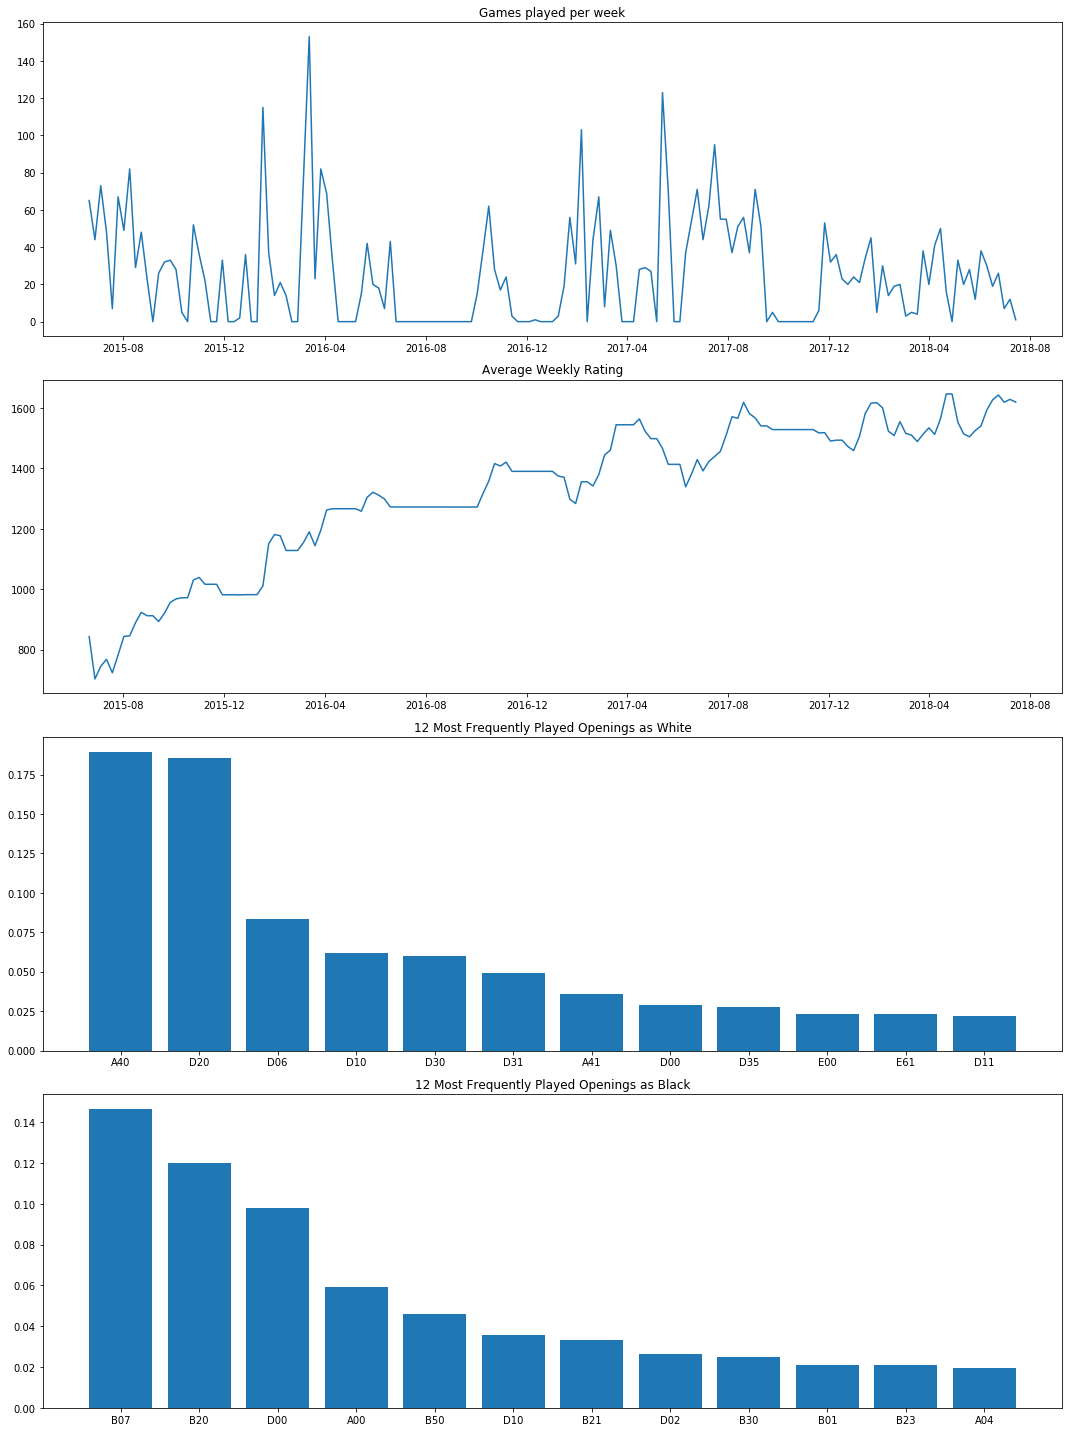

In [44]:
fig, ax = plt.subplots(4, figsize=(15, 20))


blitz_chess_df = df[(df['rules'] == 'chess') & (df['time_class'] == 'blitz')]

ax[0].plot(blitz_chess_df.resample('W', on='end_time').size())
ax[0].set_title('Games played per week')

ax[1].plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'))
ax[1].set_title('Average Weekly Rating')


num_of_openings = 12

games_played_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_of_openings].values
openings_white = blitz_chess_df[blitz_chess_df.player_color == 'white'].eco.value_counts(normalize=True)[:num_of_openings].index

x = np.arange(len(openings_white))

ax[2].bar(x, games_played_white)
ax[2].set_title(f'{num_of_openings} Most Frequently Played Openings as White')
ax[2].set_xticks(x)
ax[2].set_xticklabels(openings_white);

games_played_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_of_openings].values
openings_black = blitz_chess_df[blitz_chess_df.player_color == 'black'].eco.value_counts(normalize=True)[:num_of_openings].index

ax[3].bar(x, games_played_black)
ax[3].set_title(f'{num_of_openings} Most Frequently Played Openings as Black')
ax[3].set_xticks(x)
ax[3].set_xticklabels(openings_black)

fig.tight_layout();

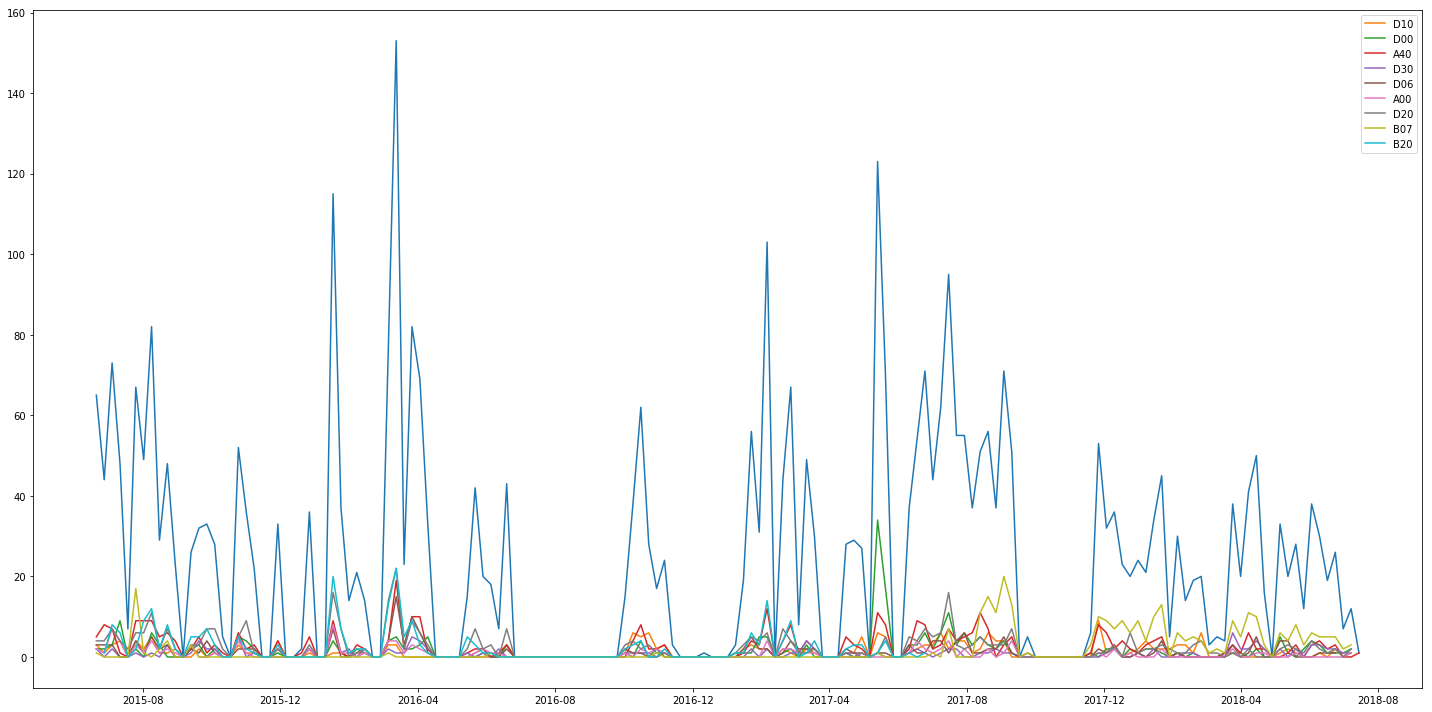

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

openings = blitz_chess_df['eco'].unique()
total_games = blitz_chess_df.shape[0]
games_per_week = blitz_chess_df.resample('M', on='end_time').size()

ax.plot(blitz_chess_df.resample('W', on='end_time').size())

for opening in openings:
    games_with_opening = blitz_chess_df[blitz_chess_df['eco'] == opening].resample('M', on='end_time').size().sum()
    percentage_of_games_with_opening = games_with_opening / total_games
    
    if (percentage_of_games_with_opening) > 0.03:
        ax.plot(blitz_chess_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size(),label=opening)
        ax.legend()
fig.tight_layout()

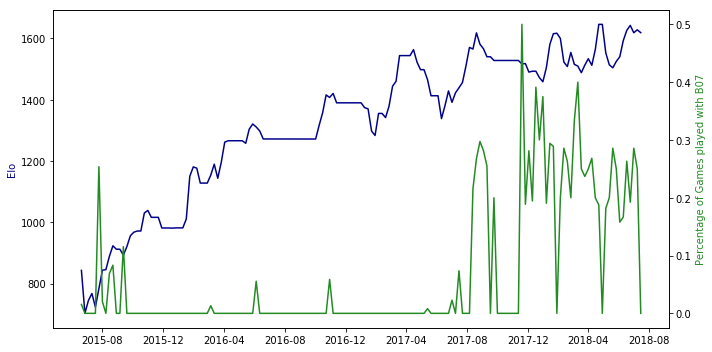

In [47]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()

opening = 'B07'
ax2.plot((blitz_chess_df[blitz_chess_df.eco == opening].resample('W', on='end_time').size() /
          blitz_chess_df.resample('W', on='end_time').size()).fillna(0),
         'forestgreen')
ax2.set_ylabel(f'Percentage of Games played with {opening}', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')

fig.tight_layout()

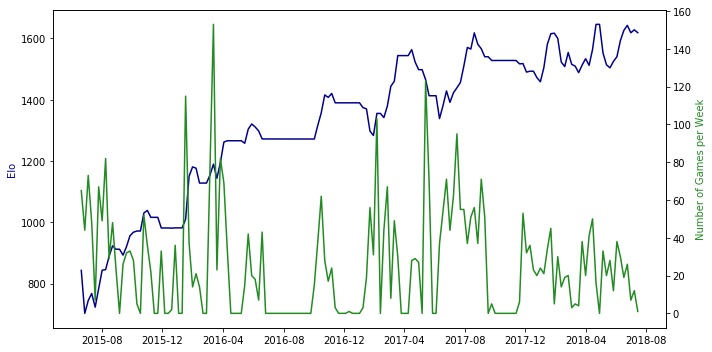

In [49]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()

ax2.plot(blitz_chess_df.resample('W', on='end_time').size(), 'forestgreen')
ax2.set_ylabel('Number of Games per Week', color='forestgreen')

ax1.plot(blitz_chess_df.resample('W', on='end_time').mean()['player_rating'].fillna(method='ffill'), 'darkblue')
ax1.set_ylabel('Elo', color='darkblue')
         
fig.tight_layout()